In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import pickle
import numpy as np
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
import os
import copy
import math

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
              
        transform = {
        'train': transforms.Compose([
        transforms.Resize(RESCALE_SIZE),
        transforms.CenterCrop(RESCALE_SIZE),
        transforms.RandomChoice( [ 
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.ColorJitter(contrast=0.9),
                                  transforms.ColorJitter(brightness=0.1),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(contrast=0.9) ], p=0.5),
                                  transforms.RandomApply( [ transforms.RandomHorizontalFlip(p=1), transforms.ColorJitter(brightness=0.1) ], p=0.5),
                                  ] ),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
        transforms.Resize(RESCALE_SIZE),
        transforms.CenterCrop(RESCALE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
        transforms.Resize(RESCALE_SIZE),
        transforms.CenterCrop(RESCALE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        }


        x = self.load_sample(self.files[index])
        x = transform[self.mode](x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')

TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))


In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.3, \
                                          stratify=train_val_labels)

train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]    

In [ ]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

dct_path_train = create_dct_path_labels(train_files, train_labels)

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        


def create_dct_from_labels(train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons
    
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files]

print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	639
agnes_skinner	100
apu_nahasapeemapetilon	436
barney_gumble	100
bart_simpson	939
carl_carlson	100
charles_montgomery_burns	835
chief_wiggum	690
cletus_spuckler	100
comic_book_guy	328
disco_stu	100
edna_krabappel	320
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1572
kent_brockman	349
krusty_the_clown	844
lenny_leonard	217
lionel_hutz	100
lisa_simpson	948
maggie_simpson	100
marge_simpson	904
martin_prince	100
mayor_quimby	172
milhouse_van_houten	755
miss_hoover	100
moe_szyslak	1016
ned_flanders	1018
nelson_muntz	251
otto_mann	100
patty_bouvier	100
principal_skinner	836
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	614
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	127


In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

In [ ]:
dataloaders_dict = {'train': DataLoader(new_train_dataset, batch_size=64, shuffle=True, num_workers=4),
                          'val': DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)}

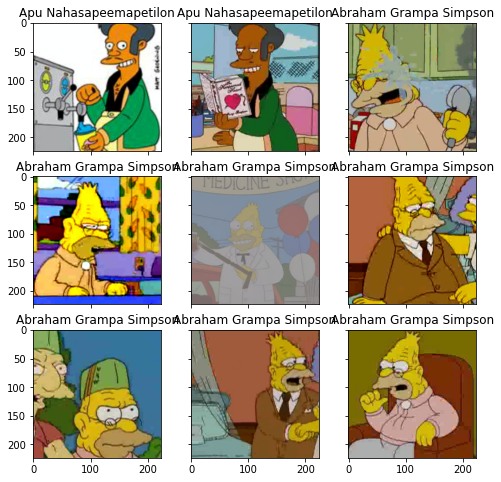

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = new_train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

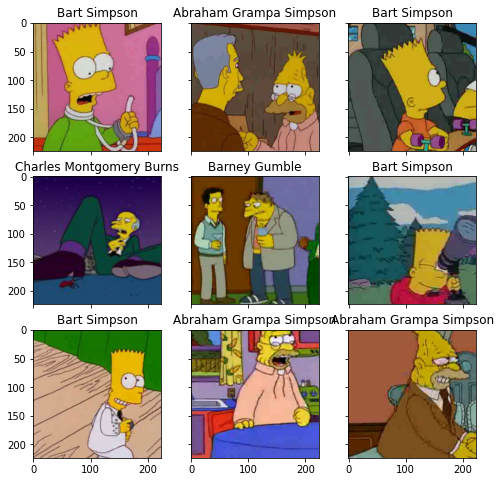

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size, learning_rate):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=learning_rate, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step(val_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))

In [ ]:
from torchvision import models

In [ ]:
model_resnet50 = models.resnet50(pretrained=True).to(DEVICE)

for param in model_resnet50.parameters():
    param.requires_grad = False



num_ftrs = model_resnet50.fc.in_features
model_resnet50.fc = nn.Sequential(nn.Linear(num_ftrs, 128),
                                nn.ReLU(inplace=True),
                                nn.Linear(128, n_classes))

In [ ]:
params_to_update = model_resnet50.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.0.weight
	 fc.0.bias
	 fc.2.weight
	 fc.2.bias


In [ ]:
import math
def find_lr(model, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0, use_gpu=True):
    model.train()
    number_in_epoch = len(dataloaders['train']) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs, labels in dataloaders['train']:
        if use_gpu:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        batch_num += 1
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values

        losses.append(loss)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    return log_lrs[10:-5], losses[10:-5]

In [ ]:
loss_fn = nn.CrossEntropyLoss() 

optimizer = torch.optim.AdamW(params_to_update, lr=1e-3, amsgrad=True)

model_resnet50 = model_resnet50.cuda()

logs, losses = find_lr(model_resnet50, dataloaders_dict, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

Text(0, 0.5, 'loss')

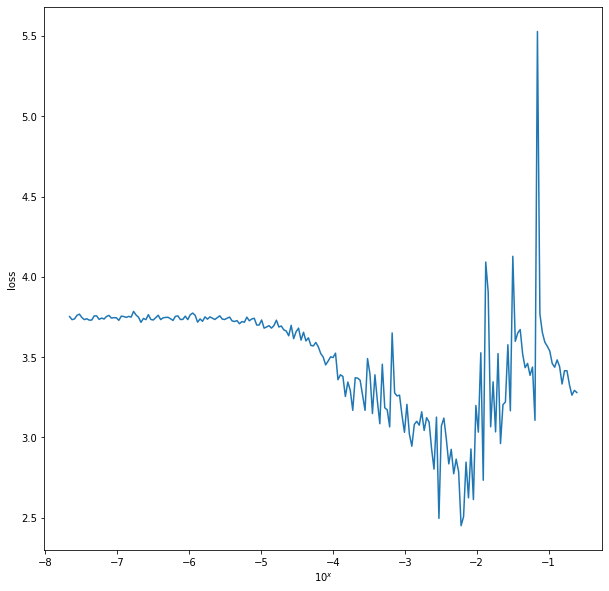

In [ ]:
# построим график для оптимального подбора lr
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")

Как видно из графика выше, оптимальным шагом обучения в случае нашей модели и нашего датасета, будет величина 10^-3.

In [ ]:
model_resnet50 = model_resnet50.cuda()

In [ ]:
history = train(new_train_dataset, val_dataset, model=model_resnet50,
                epochs=6, batch_size=32, learning_rate=1e-3)

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 2.213765793997563


epoch:  17%|█▋        | 1/6 [02:22<11:50, 142.20s/it]


Epoch 001 train_loss: 2.2138     val_loss 1.3778 train_acc 0.4489 val_acc 0.6505
loss 1.3007984773982328


epoch:  33%|███▎      | 2/6 [04:43<09:27, 141.90s/it]


Epoch 002 train_loss: 1.3008     val_loss 1.0869 train_acc 0.6551 val_acc 0.7067
loss 1.0291575238061805


epoch:  50%|█████     | 3/6 [07:06<07:06, 142.28s/it]


Epoch 003 train_loss: 1.0292     val_loss 1.0024 train_acc 0.7175 val_acc 0.7291
loss 0.8970123575214767


epoch:  67%|██████▋   | 4/6 [09:27<04:43, 141.86s/it]


Epoch 004 train_loss: 0.8970     val_loss 0.9198 train_acc 0.7556 val_acc 0.7489
loss 0.8099737746883383


epoch:  83%|████████▎ | 5/6 [11:48<02:21, 141.50s/it]


Epoch 005 train_loss: 0.8100     val_loss 0.8791 train_acc 0.7755 val_acc 0.7568
loss 0.7607614304849294


epoch: 100%|██████████| 6/6 [14:11<00:00, 141.92s/it]


Epoch 006 train_loss: 0.7608     val_loss 0.9093 train_acc 0.7880 val_acc 0.7428


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

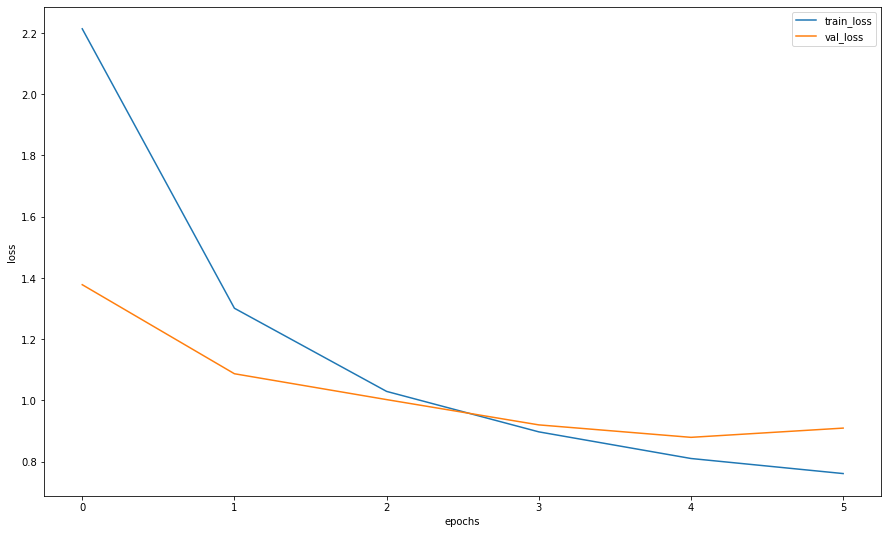

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
import copy

model_only_fc_layer = copy.deepcopy(model_resnet50.state_dict())
torch.save(model_only_fc_layer, "model_only_fc_layer.pth")

Теперь "разморозим" все остальные слои нашей нейронной сети, чтобы дообучить ее конкретно под наш датасет.

In [ ]:
for param in model_resnet50.parameters():
    param.requires_grad = True

In [ ]:
params_to_update = model_resnet50.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model_resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

Запустим обучение на этот раз уже на 12 эпохах с параметром learning_rate=1e-4, но все так же с размером batch_size = 32.

In [ ]:
history = train(new_train_dataset, val_dataset, model=model_resnet50, epochs=12, batch_size=32,
               learning_rate=1e-4)

epoch:   0%|          | 0/12 [00:00<?, ?it/s]

loss 0.5315763638945475


epoch:   8%|▊         | 1/12 [02:36<28:36, 156.01s/it]


Epoch 001 train_loss: 0.5316     val_loss 0.2703 train_acc 0.8597 val_acc 0.9311
loss 0.18137615504771198


epoch:  17%|█▋        | 2/12 [05:12<26:01, 156.15s/it]


Epoch 002 train_loss: 0.1814     val_loss 0.2865 train_acc 0.9527 val_acc 0.9261
loss 0.11149608963394525


epoch:  25%|██▌       | 3/12 [07:48<23:26, 156.23s/it]


Epoch 003 train_loss: 0.1115     val_loss 0.1829 train_acc 0.9707 val_acc 0.9556
loss 0.08248083028751516


epoch:  33%|███▎      | 4/12 [10:25<20:49, 156.23s/it]


Epoch 004 train_loss: 0.0825     val_loss 0.1983 train_acc 0.9777 val_acc 0.9535
loss 0.04992923554504849


epoch:  42%|████▏     | 5/12 [13:01<18:13, 156.21s/it]


Epoch 005 train_loss: 0.0499     val_loss 0.1552 train_acc 0.9865 val_acc 0.9634
loss 0.04514346432939141


epoch:  50%|█████     | 6/12 [15:38<15:38, 156.40s/it]


Epoch 006 train_loss: 0.0451     val_loss 0.2421 train_acc 0.9879 val_acc 0.9459
loss 0.03945118865451297


epoch:  58%|█████▊    | 7/12 [18:12<12:59, 155.85s/it]


Epoch 007 train_loss: 0.0395     val_loss 0.1382 train_acc 0.9889 val_acc 0.9712
loss 0.023907994617088122


epoch:  67%|██████▋   | 8/12 [20:44<10:18, 154.72s/it]


Epoch 008 train_loss: 0.0239     val_loss 0.1509 train_acc 0.9931 val_acc 0.9693
loss 0.021407507980941303


epoch:  75%|███████▌  | 9/12 [23:26<07:50, 156.72s/it]


Epoch 009 train_loss: 0.0214     val_loss 0.2455 train_acc 0.9950 val_acc 0.9481
loss 0.02023664896471846


epoch:  83%|████████▎ | 10/12 [26:00<05:12, 156.07s/it]


Epoch 010 train_loss: 0.0202     val_loss 0.1576 train_acc 0.9942 val_acc 0.9682
loss 0.01974985390564393


epoch:  92%|█████████▏| 11/12 [28:41<02:37, 157.50s/it]


Epoch 011 train_loss: 0.0197     val_loss 0.1764 train_acc 0.9940 val_acc 0.9693
loss 0.014419492013345029


epoch: 100%|██████████| 12/12 [31:16<00:00, 156.40s/it]


Epoch 012 train_loss: 0.0144     val_loss 0.1553 train_acc 0.9958 val_acc 0.9752


In [ ]:
model_resnet50_25epoch_weights = copy.deepcopy(model_resnet50.state_dict())
torch.save(model_resnet50_25epoch_weights, "model_resnet50_25epoch_weights.pth")

In [ ]:
# model_resnet50.load_state_dict(torch.load("model_pre_weights.pth"))

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

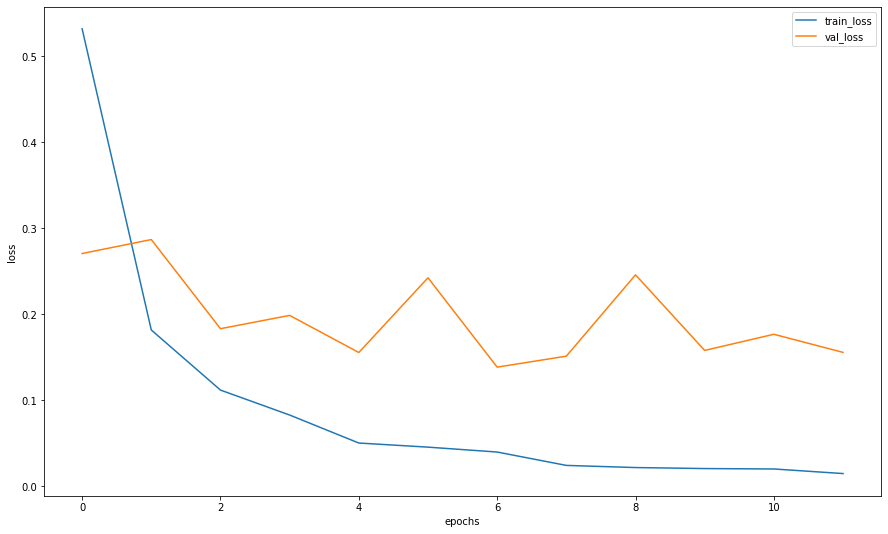

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet50, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnet50, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.9500000000000001

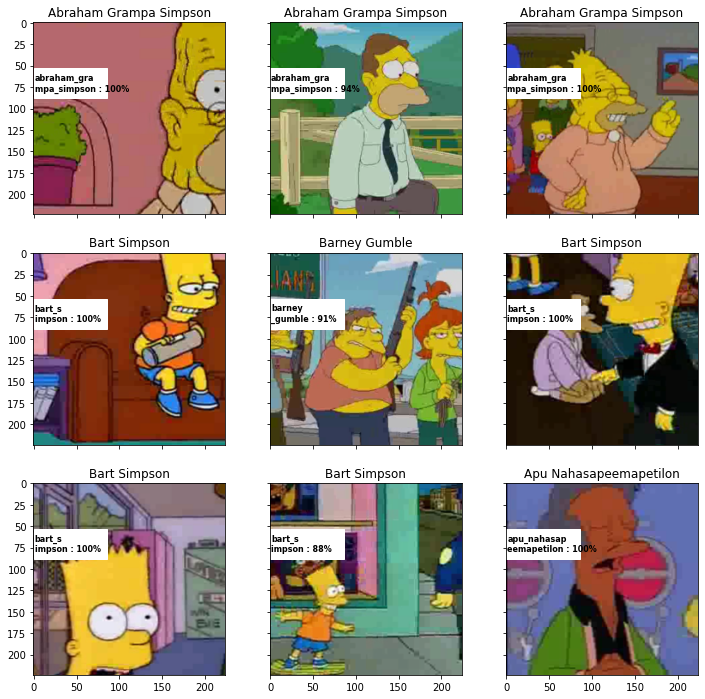

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_resnet50, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')